Total time taken: 10 seconds


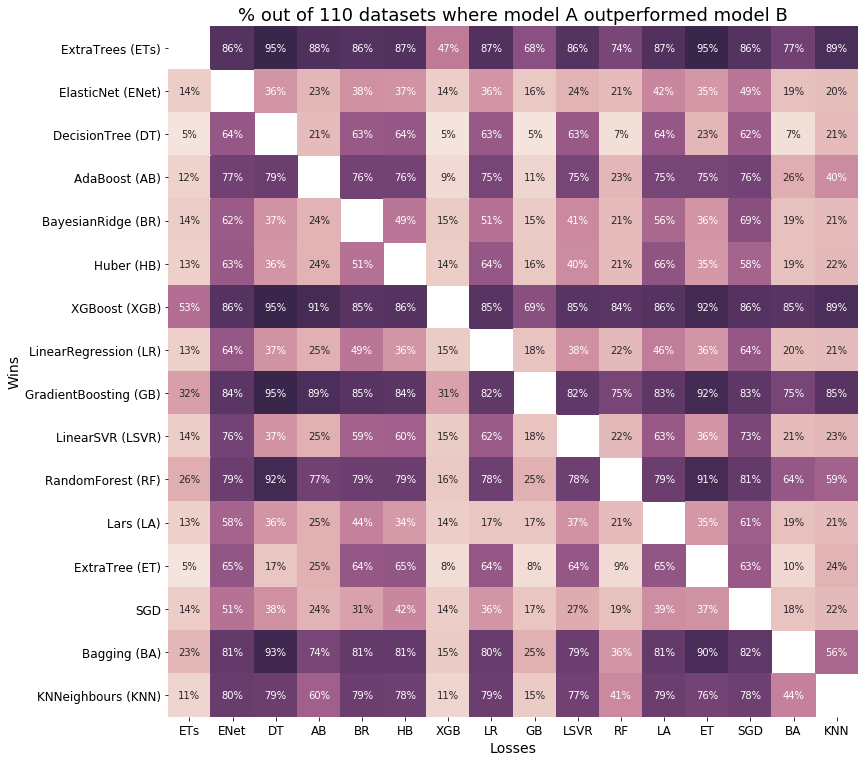

In [37]:
import sys
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import warnings
import seaborn as sb

import plotly
import plotly.graph_objs as go
from plotly import tools
import plotly.io as pio


warnings.filterwarnings('ignore')

start_time = time.time()
folder_name = "european_days/"
clf_names_dir = os.listdir(folder_name)

model_nice_dict = {
    'ExtraTrees': 'ETs',
    'ElasticNet': 'ENet',
    'DecisionTree': 'DT',
    'AdaBoost': 'AB',
    'BayesianRidge': 'BR',
    'Huber': 'HB',
    'XGBoost': 'XGB',
    'LinearRegression': 'LR',
    'GradientBoosting': 'GB',
    'LinearSVR': 'LSVR',
    'RandomForest': 'RF',
    'Lars': 'LA',
    'ExtraTree': 'ET',
    'SGD': 'SGD',
    'Bagging': 'BA',
    'KNNeighbours': 'KNN',
}

model_nice_dict_y = {
    'ExtraTrees': 'ExtraTrees (ETs)',
    'ElasticNet': 'ElasticNet (ENet)',
    'DecisionTree': 'DecisionTree (DT)',
    'AdaBoost': 'AdaBoost (AB)',
    'BayesianRidge': 'BayesianRidge (BR)',
    'Huber': 'Huber (HB)',
    'XGBoost': 'XGBoost (XGB)',
    'LinearRegression': 'LinearRegression (LR)',
    'GradientBoosting': 'GradientBoosting (GB)',
    'LinearSVR': 'LinearSVR (LSVR)',
    'RandomForest': 'RandomForest (RF)',
    'Lars': 'Lars (LA)',
    'ExtraTree': 'ExtraTree (ET)',
    'SGD': 'SGD',
    'Bagging': 'Bagging (BA)',
    'KNNeighbours': 'KNNeighbours (KNN)',
}

x_labels = list(model_nice_dict.values())
y_labels = list(model_nice_dict_y.values())


def check_file(f_name):
    for clf in clf_names_dir:
        data_path = folder_name + clf
        files = [f for f in os.listdir(data_path)]
        if f_name not in files:
            return False
            break
    return True

clf_names = list()
r2_dict = dict()

for clf in clf_names_dir:
    data_path = folder_name + clf
    files = [f for f in os.listdir(data_path)]
    r2_scores = list()
    r2_dict[clf] = list()
    for f_name in files:
        if_file_present = check_file(f_name)
        if if_file_present is True:
            common_fileset.append(f_name)
            f_path = data_path + "/" + f_name
            df = pd.read_csv(f_path, sep="\t")
            rank_test_score = df[df["rank_test_score"] == 1]
            mean_test_score = rank_test_score["mean_test_score"]
            r2_scores.append(mean_test_score.iloc[0])
    r2_dict[clf] = r2_scores     
    clf_names.append(clf)
    
n_clf = len(clf_names)

performance_datasets = np.zeros(shape=(n_clf,n_clf), dtype=float)

for x, clf_x in enumerate(clf_names):
    for y, clf_y in enumerate(clf_names):
        x_perf = r2_dict[clf_x]
        y_perf = r2_dict[clf_y]
        n_datasets = len(r2_dict[clf_x])
        x_g_y = len([1 for (a,b) in zip(x_perf, y_perf) if a > b]) / float(n_datasets)
        y_g_x = len([1 for (a,b) in zip(x_perf, y_perf) if b > a]) / float(n_datasets)
        performance_datasets[x][y] = x_g_y
        performance_datasets[y][x] = y_g_x

# plot heatmap

mask_matrix = []
for x in range(n_clf):
    for y in range(n_clf):
        mask_matrix.append(x == y)
mask_matrix = np.array(mask_matrix).reshape(n_clf, n_clf)

plt.figure(figsize=(12, 12))
sb.heatmap(np.round((performance_datasets), 2), fmt='0.0%',
           mask=mask_matrix,
           cmap=sb.cubehelix_palette(500, light=0.95, dark=0.15),
           square=True, annot=True, vmin=0., vmax=1.0,
           xticklabels=x_labels, yticklabels=y_labels, cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Losses', fontsize=14)
plt.ylabel('Wins', fontsize=14)
plt.title('% out of ' + str(n_datasets) + ' datasets where model A outperformed model B', fontsize=18)
h = plt.gcf()
plt.tight_layout()

end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))
